<a href="https://colab.research.google.com/github/yukontaf/HeadRepo/blob/main/novozymesEnzymeStabilityPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports

In [1]:
# %%script echo skipping
import pandas as pd, numpy as np, matplotlib.pyplot as plt, matplotlib
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder

import tensorflow_datasets as tfds
import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# os.environ['TF_ENABLE_ONEDNN_OPTS'] = '1'
from tensorflow import keras
tf.config.run_functions_eagerly(True)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.losses import MeanAbsoluteError, MeanSquaredError, SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.optimizers import Adagrad, Adadelta, Adam, Adamax, Ftrl, Nadam, SGD, RMSprop 
from tensorflow.keras.layers import Bidirectional, Dense, LSTM, GRU, Conv1D, GlobalAveragePooling1D, Lambda, Flatten, Dropout, Embedding, Input, Normalization,\
Concatenate, Reshape, Conv1DTranspose, TimeDistributed, LayerNormalization, MaxPool1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, TensorBoard
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.utils import plot_model
from tensorflow.estimator import WarmStartSettings
from tensorflow.keras import backend as K
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Sequential
from tqdm import tqdm
matplotlib.style.use("seaborn-whitegrid")
pd.set_option("display.width", 5000)
pd.set_option("display.max_columns", 60)
plt.rcParams["figure.figsize"] = (15, 10)
import datetime
%config InlineBackend.figure_format = 'retina'
from tensorflow.keras.utils import to_categorical

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.simplefilter('ignore')
pd.set_option('display.float_format', lambda x: '%.3f' % x)
# AUTO = tf.data.experimental.AUTOTUNE

In [ ]:
%%script echo skipping
%%capture
!pip install ipdb
# !pip install gdown 
!pip install optuna
!apt install --assume-yes --allow-change-held-packages libcudnn8=8.4.1.50-1+cuda11.6

skipping


In [ ]:
%%script echo skipping
import optuna
import pdb
from optuna.trial import TrialState

skipping


In [2]:
# %%script echo skipping
!gdown 12ceraaz41xJ503VhZlU-WnBB5pR8QWWf
!gdown 1mocZNvYWzWL9U-kygm9QU4ejuJoO0jyo

Downloading...
From: https://drive.google.com/uc?id=12ceraaz41xJ503VhZlU-WnBB5pR8QWWf
To: /content/train.feather
100% 12.2M/12.2M [00:00<00:00, 231MB/s]
Downloading...
From: https://drive.google.com/uc?id=1mocZNvYWzWL9U-kygm9QU4ejuJoO0jyo
To: /content/test.feather
100% 45.8k/45.8k [00:00<00:00, 64.4MB/s]


In [79]:
norm = lambda x: (x-x.mean())/x.std()
df = pd.read_feather('/content/train.feather').drop('data_source', axis=1).dropna()
tm, ph = df['tm'], df['pH']
bins_tm, bins_ph = list(range(0,110,10)), np.arange(start=0,stop=10,step=0.5)
tm_cut, ph_cut = pd.cut(tm, bins_tm), pd.cut(ph, bins_ph)
df['tm_bin'], df['ph_bin'] = tm_cut, ph_cut
train = df.sample(frac = 0.8)
val = df.drop(train.index, axis=0)
test = pd.read_feather('/content/test.feather').drop('data_source', axis=1).dropna()

In [80]:
def split_seq(df):
    sentences = np.array([
    df[['protein_sequence']].to_numpy()[:, 0],
])
    splitted= []
    for i in sentences[0, :]:
        splitted.append(list(i))

    return np.array(splitted)

train_seq, val_seq, test_seq = split_seq(train), split_seq(val), split_seq(test)
le = LabelEncoder()
le.fit(df[['tm_bin']])

train_ph, val_ph, test_ph = train['pH'].to_numpy().reshape((len(train), 1)), val['pH'].to_numpy().reshape((len(val), 1)), test['pH'].to_numpy().reshape((len(test), 1))
train_tm, val_tm = train['tm'].to_numpy().reshape((len(train), 1)), val['tm'].to_numpy().reshape((len(val), 1))
train_labels, val_labels = le.fit_transform(train[['tm_bin']].to_numpy()).reshape((-1, 1, 1)).astype('float32'), le.fit_transform(val[['tm_bin']].to_numpy()).reshape((-1, 1, 1)).astype('float32')
le.fit(df[['ph_bin']])
train_ph_labels, val_ph_labels = le.fit_transform(train['ph_bin']), le.fit_transform(val['ph_bin'])
# train_labels, val_labels = keras.utils.to_categorical(train_labels), keras.utils.to_categorical(val_labels)
# train_labels, val_labels = tf.cast(train_labels, 'float32'), tf.cast(val, 'float32')

LabelEncoder()

LabelEncoder()

In [5]:
# %%script echo skipping
df['protein_sequence'].apply(lambda x: len(x)).quantile(0.90)

842.0

In [34]:
# %%script echo skipping
max_length = 256
trunc_type='post'
embedding_dim = 64
train_size, val_size = len(train_seq), len(val_seq)

### Tokenization

In [86]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_seq)
sequences = tokenizer.texts_to_sequences(train_seq)

In [87]:

train_seq = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)
vocab_size = len(tokenizer.word_index)
train = Concatenate(axis=1)([tf.cast(train_seq.reshape(train_size, max_length, 1), 'float32'), tf.cast(train_ph_labels.reshape(train_size, 1, 1), 'float32'), train_labels])

val_seq = tokenizer.texts_to_sequences(val_seq)
val_seq = pad_sequences(val_seq,maxlen=max_length)
val = Concatenate(axis=1)([tf.cast(val_seq.reshape(val_size, max_length, 1), 'float32'), tf.cast(val_ph_labels.reshape(val_size, 1, 1), 'float32'), val_labels ])


tokenizer.fit_on_texts(test_seq)
test_seq = tokenizer.texts_to_sequences(test_seq)
test_seq = pad_sequences(test_seq, maxlen=max_length)
# test = np.append(test_seq, test_ph, 1)

In [ ]:
BATCH_SIZE = 2048
def mapping(sequence):
    return sequence[:-1], tf.reshape(sequence[-1], [])
train = tf.data.Dataset.from_tensor_slices(train).map(mapping).shuffle(len(train_seq)).batch(BATCH_SIZE).prefetch(1)
val = tf.data.Dataset.from_tensor_slices(val).map(mapping).shuffle(len(val_seq)).batch(BATCH_SIZE).prefetch(1)


In [ ]:
# %pdb
import random, ipdb
def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(11)]) - 1
    
    for d in range(11):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            # pdb.set_trace()
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, 10)
            dn = (d + inc) % 10
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
            
    return np.array(pairs), np.array(labels)


def create_pairs_on_set(sequences, labels):
    
    digit_indices = [np.where(labels == i)[0] for i in range(11)]
    # pdb.set_trace()
    pairs, y = create_pairs(sequences, digit_indices)
    y = y.astype('float32')
    
    return pairs, y


train_pairs, train_y = create_pairs_on_set(train_seq, train_labels)
val_pairs, val_y = create_pairs_on_set(val_seq, val_labels)


In [ ]:
def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - y_pred, 0))
        return (y_true * square_pred + (1 - y_true) * margin_square)
    return contrastive_loss

from tensorflow.keras.losses import Loss

class ContrastiveLoss(Loss):
  def __init__(self, margin=1):
    super().__init__()
    self.margin = margin

  def __call__(self, y_true, y_pred):
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(self.margin - y_pred, 0))
    return (1-y_true)*square_pred + y_true*margin_square

In [ ]:
#@title
# %pdb
class MyModel(tf.keras.Model):
  def __init__(self, lstm_layers, emb_dim, lstm_units, dropout_rate):
    super(MyModel, self).__init__()
    self.lstm_layers, self.emb_dim, self.lstm_units, self.dropout_rate = lstm_layers, emb_dim, lstm_units, dropout_rate
    self.input_ph = tf.keras.layers.Input((1,))
    self.input_seq = tf.keras.layers.Input((500, ))
    self.seq_layers =  [] 
    self.seq_layers.extend([tf.keras.layers.Embedding(21, emb_dim, name='embedding'),
                        tf.keras.layers.Conv1D(filters=128, kernel_size=5, activation='relu'),
                        tf.keras.layers.Dropout(dropout_rate),  
                        tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
                        tf.keras.layers.Dropout(dropout_rate),
                        *[tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(i, return_sequences=True, name=f'LSTM_{i}')) for j in range(lstm_layers-1) for i in lstm_units],
                        ])
    for i in range(len(self.seq_layers)):
      vars(self)[f'SEQ_LAYER_{i}'] = self.seq_layers[i]

    self.ph_layers = [
                      tf.keras.layers.Dense(512, name='dense1_ph', activation='relu'),
                      tf.keras.layers.Dropout(dropout_rate), 
                      tf.keras.layers.Dense(256, name='dense2_ph', activation='relu'),
                      tf.keras.layers.Dropout(dropout_rate), 
                      tf.keras.layers.Dense(128, name='dense3_ph', activation='relu'),
                      # tf.keras.layers.Dropout(dropout_rate),  
                      # tf.keras.layers.Dense(1, name='output_ph')
                      ]

    self.lambda_layer = tf.keras.layers.Lambda(function=concat, name='lambda_layer')
    self.flatten = tf.keras.layers.Flatten(name='flatten')
    self.dense_combined = tf.keras.layers.Dense(64, activation='relu', name='dense_combined')
    self.lambda_helper = tf.keras.layers.Lambda(lambda x: tf.reshape(x, (-1, 64, 1)))
    self.lstm_dense = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512))
    self.last_dense = tf.keras.layers.Dense(1, name='output')

  def call(self, inputs):
    seq, ph = inputs
    SEQ_LAYER_0 = vars(self)['SEQ_LAYER_0']
    x = SEQ_LAYER_0(seq)
    for i in range(1, self.lstm_layers):
        SEQ_LAYER_i = vars(self)[f'SEQ_LAYER_{i}']
        x = SEQ_LAYER_i(x)

    # for layer in self.seq_layers:
    #   seq = layer(seq)

    for layer in self.ph_layers:
      ph = layer(ph)

    x = self.lambda_layer([x, tf.tile(tf.reshape(ph, (-1, 128, 1)), (1, 1, x.shape[-1]))])
    x = self.flatten(x)
    x = self.dense_combined(x)
    x = self.lambda_helper(x)
    # x = self.lstm_dense(x)
    x = self.last_dense(x)
    return x
    

In [ ]:
#@title
TRAIN_STEPS = 15
PRUNING_INTERVAL_STEPS = 50
def objective(trial):    
  lstm_layers = trial.suggest_int('lstm_layers', 1, 7)
  emb_dim = trial.suggest_int('emb_dim', 256, 1024)
  lstm_units = []
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-7, 1)
  for i in range(lstm_layers):
    lstm_units.append(trial.suggest_int(f'lstm_units_l{i}', 16, 512))
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1)
  optimizer = trial.suggest_categorical('optimizer', [Adagrad, Adadelta, Adam, Adamax, Ftrl, Nadam, SGD, RMSprop])
  regressor = MyModel(lstm_layers, emb_dim, lstm_units, dropout_rate)
  loss_obj = tf.keras.metrics.MeanAbsoluteError(name='loss_obj')
  regressor.compile(loss=loss_obj, optimizer=optimizer(learning_rate=learning_rate))
  losses, n_train_iter, step = [], len(get_training_dataset(train)), 0
  for epoch in range(1):
    print(f'Epoch # {epoch} started')
    for batch in tqdm(get_training_dataset(train)):
      predictions = regressor([batch[0], batch[1]], training=True)
      loss = loss_obj(batch[2], predictions)
      losses.append(loss)
      if step > n_train_iter//2:
        intermediate_value = loss
        if intermediate_value < best_loss:
            raise optuna.TrialPruned()
      step += 1
      best_loss = min(losses)
    print(f'Training Loss {loss:.2f}, Best Loss: {best_loss:.2f}')
    for val_batch in tqdm(get_validation_dataset(val)):
      predictions = regressor([val_batch[0], val_batch[1]], training=False)
      val_loss = loss_obj(val_batch[2], predictions)
    print(f'Validation Loss {val_loss:.2f}')
  return val_loss

In [ ]:
#@title
# study = optuna.create_study(direction="minimize")
# study.optimize(objective, n_trials=100)
# pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
# complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

In [ ]:
#@title
# print("Best trial:")
# trial = study.best_trial

# trial

### Base Model

In [ ]:
initializer = RandomNormal()

In [ ]:
#@title
def model2(inputs):
    training = tf.estimator.ModeKeys.TRAIN
    seq = inputs

    # seq = Embedding(257, 256)(seq)
    seq = Conv1D(filters=32, kernel_size=5,
                      strides=2, padding="valid",
                      activation="relu",
                 )(seq)
    seq = Conv1D(filters=32, kernel_size=5,
                      strides=2, padding="valid",
                      activation="relu",
                 )(seq)
    seq = Bidirectional(LSTM(20, return_sequences=True, recurrent_dropout=0.2))(seq)
    seq = Bidirectional(LSTM(20, recurrent_dropout=0.2))(seq)
    output = Dense(11, activation='softmax', kernel_initializer=initializer)(seq)
    model = Model(inputs=inputs, outputs=output)
    return model

In [ ]:
#@title
inputs_seq = Input((max_length+1,1))
model = model2(inputs_seq)
adam, sgd, rms = Adam(1e-5), SGD(1e-4), RMSprop(1e-4)
loss_fn = SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=adam, loss=loss_fn, metrics=['sparse_categorical_accuracy'], steps_per_execution = 50)

In [ ]:
def scheduler(epoch, lr):
  if epoch < 2:
    return lr
  else:
    return lr * tf.math.exp(-0.1)
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
scheduler = LearningRateScheduler(scheduler)
early_stopping = EarlyStopping(patience=3, min_delta=0.05, baseline=0.4, mode='max', monitor='val_accuracy', restore_best_weights=True, verbose=1)
tensorboard = tf.keras.callbacks.TensorBoard(logdir)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 257, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 127, 32)           192       
                                                                 
 conv1d_1 (Conv1D)           (None, 62, 32)            5152      
                                                                 
 bidirectional (Bidirectiona  (None, 62, 40)           8480      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 11)                451   

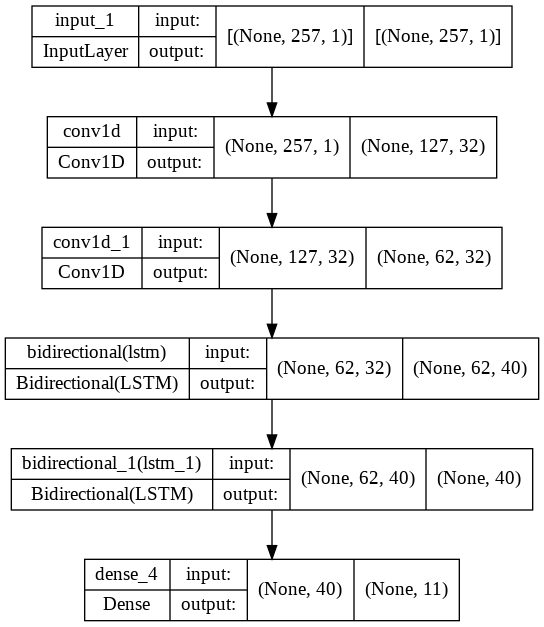

In [ ]:
model.summary()
plot_model(model, to_file='model.png', show_shapes=True)

In [ ]:
model = tf.keras.models.load_model('/content/model')

In [ ]:
%load_ext tensorboard

In [ ]:
num_sequences = len(train_seq)
steps_per_epoch = num_sequences // BATCH_SIZE
validation_steps = num_sequences // BATCH_SIZE


### LNSimpleRNN

In [ ]:
class LNSimpleLSTMCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_lstm_cell = LSTM(units, activation=None)
        self.layer_norm = LayerNormalization()
        self.activation = keras.activations.get(activation)
    def get_initial_state(self, inputs=None, batch_size=8, dtype=None):
        if inputs is not None:
            # batch_size = tf.shape(inputs)[0]
            dtype = inputs.dtype
        return [tf.zeros([batch_size, self.state_size], dtype=dtype)]
    def call(self, inputs, states):
        outputs, new_states = self.simple_lstm_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [ ]:
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

In [20]:
filepath = os.path.sep.join(['', 'content', 'WaveNetRegressor(StableImproving).h5'])
model_chkpt = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', save_freq=1)

In [48]:
import numpy as np
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    LSTM(20, return_sequences=True),
    LayerNormalization(),
    LSTM(20),
    LayerNormalization(),
   Dense(1,)
])

model.compile(loss=MeanAbsoluteError(), optimizer="adam")
history = model.fit(train_dataset, validation_data=val_dataset, epochs=20, callbacks=[model_chkpt])

Epoch 1/20
25/25 [==============================] - 4s 122ms/step - loss: 0.7642 - val_loss: 49.4660
Epoch 2/20
25/25 [==============================] - 3s 100ms/step - loss: 0.7002 - val_loss: 49.3969
Epoch 3/20
25/25 [==============================] - 3s 113ms/step - loss: 0.6948 - val_loss: 49.4149
Epoch 4/20
25/25 [==============================] - 3s 98ms/step - loss: 0.6937 - val_loss: 49.4145
Epoch 5/20
25/25 [==============================] - 3s 101ms/step - loss: 0.6927 - val_loss: 49.4239
Epoch 6/20
25/25 [==============================] - 3s 103ms/step - loss: 0.6923 - val_loss: 49.3788
Epoch 7/20
25/25 [==============================] - 3s 102ms/step - loss: 0.6925 - val_loss: 49.4145
Epoch 8/20
25/25 [==============================] - 3s 105ms/step - loss: 0.6920 - val_loss: 49.3979
Epoch 9/20
 6/25 [======>.......................] - ETA: 1s - loss: 0.6893

KeyboardInterrupt: ignored

In [ ]:
model.save('/content/LNSimpleRNN')

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rnn_10 (RNN)                (1024, 257, 20)           480       
                                                                 
 rnn_11 (RNN)                (1024, 20)                860       
                                                                 
 time_distributed_5 (TimeDis  multiple                 0 (unused)
 tributed)                                                       
                                                                 
Total params: 1,340
Trainable params: 1,340
Non-trainable params: 0
_________________________________________________________________


In [ ]:
%tensorboard --logdir logdir

In [ ]:
import shutil
shutil.rmtree('/content/model')
model.save('/content/model')

In [ ]:
#@title
seq, ph, tm = train[:,:-2], train[:,-2].reshape(-1,1), train[:,-1].reshape(-1,1)
scaler_ph, scaler_tm = StandardScaler(), StandardScaler()
train_ph, train_tm  = np.array(scaler_ph.fit_transform(ph)), np.array(scaler_tm.fit_transform(tm))
scaler_ph.fit(val[:,-2].reshape(-1,1)), scaler_tm.fit(val[:,-1].reshape(-1,1))
val_seq, val_ph, val_tm = val[:,:-2], scaler_ph.inverse_transform(val[:,-2].reshape(-1,1)), scaler_tm.inverse_transform(val[:,-1].reshape(-1,1))

In [ ]:
#@title
class G:
    TIME, SERIES = list(range(max_length)), sequences
    SPLIT_TIME = int(max_length*0.2)
    WINDOW_SIZE = 20
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = train_seq.shape[0]
    LR = 2e-6

In [ ]:
#@title
def windowed_seq(ind, series=G.SERIES, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE,
                     shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    seq = tf.data.Dataset.from_tensor_slices(series[ind])
    seq = seq.window(window_size + 1, shift=1, drop_remainder=True)
    seq = seq.flat_map(lambda window: window.batch(window_size + 1))
    # seq = seq.shuffle(shuffle_buffer)
    seq = seq.map(lambda window: (window[:-1], window[-1]))
    seq = seq.batch(batch_size).prefetch(1)
    return seq

### WaveNet

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

def WaveNet(inputs):
  seq = inputs
  for rate in (1, 2, 4, 8) * 2:
      seq = Conv1D(filters=20, kernel_size=2, padding="causal",
                                    activation="relu", dilation_rate=rate)(seq)
  seq = Conv1D(filters=10, kernel_size=1)(seq)
  # seq = MaxPool1D()(seq)
  seq = LSTM(20)(seq)
  seq = LayerNormalization()(seq)
  seq = Dense(11, activation='softmax')(seq)
  model = Model(inputs=inputs, outputs=seq)
  return model

inputs = Input((max_length+1, 1))
model = WaveNet(inputs)
model.compile(loss=SparseCategoricalCrossentropy(from_logits=True), optimizer="adam", metrics=['accuracy'])

Model: "model_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_45 (InputLayer)       [(None, 851, 1)]          0         
                                                                 
 conv1d_108 (Conv1D)         (None, 851, 20)           60        
                                                                 
 conv1d_109 (Conv1D)         (None, 851, 20)           820       
                                                                 
 conv1d_110 (Conv1D)         (None, 851, 20)           820       
                                                                 
 conv1d_111 (Conv1D)         (None, 851, 20)           820       
                                                                 
 conv1d_112 (Conv1D)         (None, 851, 20)           820       
                                                                 
 conv1d_113 (Conv1D)         (None, 851, 20)           820

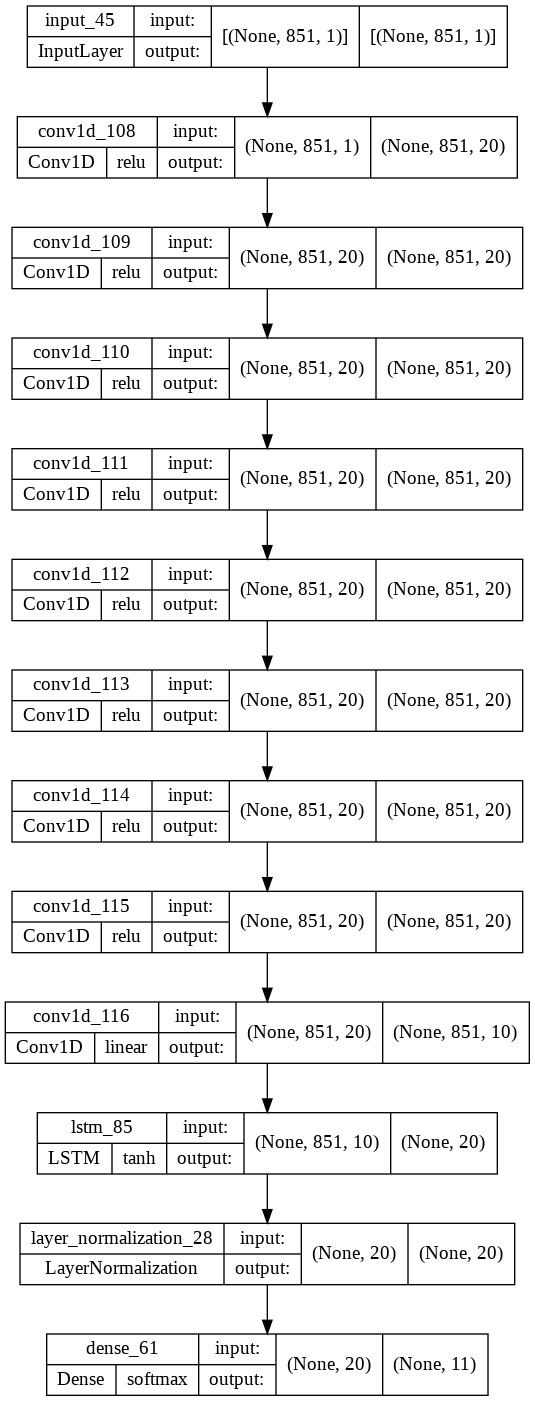

In [ ]:
model.summary()
plot_model(model, show_shapes=True, show_layer_activations=True)

In [ ]:
history = model.fit(train, epochs=20,
                    validation_data=val, callbacks=[model_chkpt])

Epoch 1/20
13/13 [==============================] - 7s 468ms/step - loss: 1.9328 - accuracy: 0.3561 - val_loss: 1.7493 - val_accuracy: 0.4085
Epoch 2/20
13/13 [==============================] - 6s 423ms/step - loss: 1.7214 - accuracy: 0.4157 - val_loss: 1.7260 - val_accuracy: 0.4085
Epoch 3/20
13/13 [==============================] - 6s 429ms/step - loss: 1.7047 - accuracy: 0.4157 - val_loss: 1.7122 - val_accuracy: 0.4085
Epoch 4/20
13/13 [==============================] - 6s 422ms/step - loss: 1.6937 - accuracy: 0.4157 - val_loss: 1.7021 - val_accuracy: 0.4085
Epoch 5/20
13/13 [==============================] - 6s 420ms/step - loss: 1.6836 - accuracy: 0.4157 - val_loss: 1.6926 - val_accuracy: 0.4085
Epoch 6/20
13/13 [==============================] - 6s 418ms/step - loss: 1.6709 - accuracy: 0.4157 - val_loss: 1.6767 - val_accuracy: 0.4085
Epoch 7/20
13/13 [==============================] - 6s 417ms/step - loss: 1.6515 - accuracy: 0.4227 - val_loss: 1.6564 - val_accuracy: 0.4186
Epoch 

### WaveNet Regression Variation

In [39]:
scaler = StandardScaler()
scaler.fit(np.reshape(tm.to_numpy(), (-1,1)))
train_tm = scaler.transform(train_tm)

StandardScaler()

In [40]:
train = Concatenate(axis=1)([tf.cast(train_seq.reshape(train_size, max_length, 1), 'float32'), tf.cast(train_ph_labels.reshape(train_size, 1, 1), 'float32'), tf.reshape(train_tm, (-1,1,1))])
val = Concatenate(axis=1)([tf.cast(val_seq.reshape(val_size, max_length, 1), 'float32'), tf.cast(val_ph_labels.reshape(val_size, 1, 1), 'float32'), tf.reshape(val_tm, (-1,1,1)) ])


In [58]:
BATCH_SIZE = 512
def mapping(sequence):
    return sequence[:-1], tf.reshape(sequence[-1], [])
train_dataset = tf.data.Dataset.from_tensor_slices(train).map(mapping).shuffle(len(train_seq)).batch(BATCH_SIZE).prefetch(1)
val_dataset = tf.data.Dataset.from_tensor_slices(val).map(mapping).shuffle(len(val_seq)).batch(BATCH_SIZE).prefetch(1)

In [ ]:
tokenizer.fit

In [77]:
tokenizer.texts_to_matrix(df[['protein_sequence']])

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.]])

In [74]:
oh = OneHotEncoder()
oh.fit(train_seq)
oh.transform(train_seq[0].reshape(-1,1))

OneHotEncoder()

ValueError: ignored

In [60]:
def WaveNetRegressor(inputs):
  seq = inputs
  for rate in (1, 2, 4, 8) * 2:
      seq = Conv1D(filters=20, kernel_size=2, padding="causal",
                                    activation="relu", dilation_rate=rate)(seq)
  seq = Conv1D(filters=10, kernel_size=1)(seq)
  # seq = MaxPool1D()(seq)
  seq = LSTM(20)(seq)
  seq = LayerNormalization()(seq)
  seq = Dense(64)(seq)
  seq = Dense(1)(seq)
  model = Model(inputs=inputs, outputs=seq)
  return model
inputs = Input((max_length+1, 1))
model = WaveNetRegressor(inputs)
model.compile(loss=MeanAbsoluteError(), optimizer='adam')

In [ ]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [61]:
history = model.fit(train_dataset, epochs=40,
                    validation_data=val_dataset, callbacks=[model_chkpt])

Epoch 1/40
49/49 [==============================] - 7s 136ms/step - loss: 0.7131 - val_loss: 49.4449
Epoch 2/40
49/49 [==============================] - 7s 136ms/step - loss: 0.6890 - val_loss: 49.3690
Epoch 3/40
49/49 [==============================] - 7s 136ms/step - loss: 0.6849 - val_loss: 49.3717
Epoch 4/40
49/49 [==============================] - 7s 135ms/step - loss: 0.6740 - val_loss: 49.4650
Epoch 5/40
49/49 [==============================] - 7s 137ms/step - loss: 0.6607 - val_loss: 49.3552
Epoch 6/40
49/49 [==============================] - 7s 136ms/step - loss: 0.6521 - val_loss: 49.3931
Epoch 7/40
49/49 [==============================] - 7s 136ms/step - loss: 0.6469 - val_loss: 49.5102
Epoch 8/40
49/49 [==============================] - 7s 135ms/step - loss: 0.6405 - val_loss: 49.3899
Epoch 9/40
49/49 [==============================] - 7s 136ms/step - loss: 0.6345 - val_loss: 49.3959
Epoch 10/40
49/49 [==============================] - 7s 136ms/step - loss: 0.6285 - val_los

KeyboardInterrupt: ignored

In [ ]:
model.save('/contents/WaveNetRegressor_val_loss=9.7')

### Autoencoder

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.keras.layers import Reshape, Conv1DTranspose, Conv1D
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, LearningRateScheduler, ModelCheckpoint, CSVLogger, ReduceLROnPlateau


In [ ]:
input_shape = (1024, 1)
batch_size = 16
kernel_size = 5
latent_dim = 2
# encoder/decoder number of CNN layers and filters per layer
layer_filters = [32, 32]

In [ ]:
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
for filters in layer_filters:
    x = Conv1D(filters=filters,
               kernel_size=kernel_size,
               activation='relu',
               strides=2,
               padding='same')(x)
shape = K.int_shape(x)

In [ ]:
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

In [ ]:
encoder = Model(inputs, latent, name='encoder')
# encoder.load_weights('/contents/encoder')
encoder.summary()
plot_model(encoder, to_file='encoder.png', show_shapes=True);

In [ ]:
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1] * shape[2] )(latent_inputs)
x = Reshape((shape[1], shape[2]))(x)

In [ ]:
for filters in layer_filters[::-1]:
    x = Conv1DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x)

In [ ]:
outputs = Conv1DTranspose(filters=1,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

In [ ]:
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='decoder.png', show_shapes=True)

In [ ]:
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()
plot_model(autoencoder, to_file='autoencoder.png', show_shapes=True)

In [ ]:
autoencoder.compile(loss=MeanAbsoluteError(), optimizer=Adam(lr=0.001))

In [ ]:
autoencoder.fit(train_seq,
                train_seq,
                validation_data=(test_seq, test_seq),
                epochs=10,
              callbacks=[EarlyStopping(
              patience=5,
              min_delta=0.05,
              baseline=1.6,
              mode='min',
              monitor='val_loss',
              restore_best_weights=True,
              verbose=1)]
)

In [ ]:
predictions = autoencoder.predict(test_seq)

### Pretraining encoder

In [ ]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [ ]:
input_a = Input(shape=((1024, 1)), name="left_input")
vect_output_a = encoder(input_a)
input_b = Input(shape=(1024,1 ), name="right_input")
vect_output_b = encoder(input_b)

In [ ]:
output = Lambda(euclidean_distance, name="output_layer", output_shape=eucl_dist_output_shape)([vect_output_a, vect_output_b])
model = Model([input_a, input_b], output)
model.summary()
plot_model(model, show_shapes=True, show_layer_names=True, to_file='outer-model.png')


In [ ]:
rms = RMSprop()
model.compile(loss=contrastive_loss_with_margin(margin=1), optimizer=rms)
history = model.fit([train_pairs[:,0], train_pairs[:,1]], train_labels, epochs=100, batch_size=128, validation_data=([val_pairs[:,0], val_pairs[:,1]], val_labels), callbacks=[EarlyStopping(
              patience=5,
              min_delta=0.05,
              baseline=0.32,
              mode='min',
              monitor='val_loss',
              restore_best_weights=True,
              verbose=1),
              ])

In [ ]:
model.save('/contents/encoder')

### Variational Autoencoder

In [ ]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [ ]:
num_labels = 11

In [ ]:
input_shape = (1024, 1)
label_shape = (num_labels, )
intermediate_dim = 512
batch_size = 128
kernel_size = 3
filters = 4
latent_dim = 2
epochs = 30
original_dim = 1024

In [ ]:
inputs = Input(shape=input_shape, name='encoder_input')
# y_labels = Input(shape=label_shape, name='class_labels')
x = Dense(intermediate_dim)(inputs)
# x = Reshape((1024, 1))(x)
x = Concatenate()([inputs, x])
for i in range(2):
    filters *= 2
    x = Conv1D(filters=filters,
               kernel_size=kernel_size,
               activation='relu',
               strides=2,
               padding='same')(x)

In [ ]:
shape = K.int_shape(x)

In [ ]:
x = Flatten()(x)
x = Dense(16, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

In [ ]:
z = Lambda(sampling,
           output_shape=(latent_dim,),
           name='z')([z_mean, z_log_var])

In [ ]:
encoder = Model(inputs,
                [z_mean, z_log_var, z], 
                name='encoder')
encoder.summary()
plot_model(encoder,
           to_file='cvae_cnn_encoder.png', 
           show_shapes=True)

In [ ]:
latent_inputs = Input(shape=(latent_dim,1), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

In [ ]:
for i in range(2):
    x = Conv1DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x)
    filters //= 2

In [ ]:
outputs = Conv1DTranspose(filters=1,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

In [ ]:
decoder = Model(latent_inputs,
                outputs, 
                name='decoder')
decoder.summary()
plot_model(decoder,
           to_file='cvae_cnn_decoder.png', 
           show_shapes=True)

In [ ]:
outputs = decoder([encoder(inputs)[1]])
cvae = Model(inputs, outputs, name='cvae')

In [ ]:
cvae([train_seq, to_categorical(tf.reshape(train_labels, (-1, 1)))])

In [ ]:
type(cvae_loss)

In [ ]:
def recon_loss(inputs,outputs):
    reconstruction_loss = 1024*mse(inputs,outputs)                                              
    return K.mean(reconstruction_loss)

def latent_loss(inputs,outputs):
    kl_loss =  -0.5*K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)    
    return K.mean(kl_loss)

def total_loss(inputs,outputs):
    reconstruction_loss = 1024*mse(inputs,outputs)                                              
    kl_loss =  -0.5*K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)   
    return K.mean(reconstruction_loss + kl_loss)

In [ ]:
cvae.compile(optimizer='rmsprop', loss=total_loss, metrics=[recon_loss, latent_loss])
cvae.summary()
tf.keras.utils.plot_model(cvae, to_file='cvae_cnn.png', show_shapes=True)

In [ ]:
cvae.fit(train_seq, train_seq, 
              epochs=epochs,
              batch_size=batch_size,
         validation_data=(val_seq, val_seq)
              )